Задание 3
Разобранными на лекции методами список того, что можно применять к метрикам-отношениям, не ограничивается. Есть огромное количество полезных материалов на эту тему. Начнем с материалов Никиты Маршалкина. К слову, вот его интервью, там тоже много интересного. 

Относительно недавно (в 2018-м году) исследователи из Яндекса разработали классный метод анализа тестов над метриками-отношениями (прямо как у нас)
Идея метода заключается в следующем:

Вместо того, чтобы заталкивать в тест «поюзерные» CTR, можно сконструировать другую метрику и анализировать ее, но при этом гарантируется (в отличие от сглаженного CTR), что если тест на этой другой метрике «прокрасится» и увидит изменения, значит изменения есть и в метрике исходной (то есть в лайках на пользователя и в пользовательских CTR).

При этом метод сам по себе очень прост. Что это за метрика такая?

Считаем общий CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠) 
Посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 
После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠  
Метод простой, гарантируется, что при приличном размере выборки (как у нас — подойдет) можно бесплатно увеличить чувствительность вашей метрики (или, по крайней мере, не сделать хуже). Как по мне, это ОЧЕНЬ круто.

Задача, которую вы будете решать на следующих шагах, такая:

Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше по сравнению с обычным CTR?
Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше по сравнению с обычным CTR?
Данные берём в том же диапазоне, в котором проводился A/B-тест.

In [15]:
import pandahouse
import swifter
import hashlib
import seaborn as sns
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib as plt

In [16]:
#подключение к серверу
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

In [17]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20250120.feed_actions
WHERE toDate(time) between '2025-01-03' and '2025-01-09'
    and exp_group in (2,1)
GROUP BY exp_group, user_id
"""
df = pandahouse.read_clickhouse(q, connection=connection)
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,39,141,0.276596
4,1,18392,7,32,0.218750


<Axes: xlabel='ctr', ylabel='Count'>

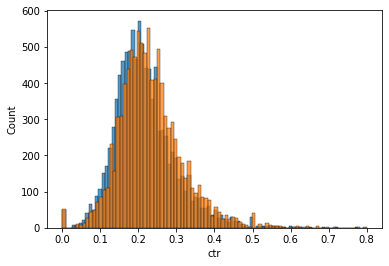

In [29]:
def linearized_likes(user_likes, CTRcontrol, views):
    linearized_likes=user_likes-CTRcontrol*views
    return linearized_likes

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20250120.feed_actions
WHERE toDate(time) between '2025-01-03' and '2025-01-09'
    and exp_group in (0,3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

CTRcontrol = df[df.exp_group == 0].likes.sum()/df[df.exp_group == 0].views.sum()

group1 = df[df.exp_group == 0].copy()
group2 = df[df.exp_group == 3].copy()
sns.histplot(group1.ctr, 
             kde = False)
sns.histplot(group2.ctr, 
             kde = False)

<Axes: xlabel='linearized_likes', ylabel='Count'>

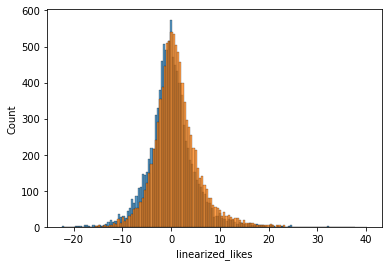

In [35]:
group1['linearized_likes'] = df.apply(
    lambda x: linearized_likes(x['likes'], x['views'], CTRcontrol), axis=1)
group2['linearized_likes'] = df.apply(
    lambda x: linearized_likes(x['likes'], x['views'], CTRcontrol), axis=1)

sns.histplot(group1.linearized_likes, 
             kde = False)
sns.histplot(group2.linearized_likes, 
             kde = False)

In [36]:
#T-тест самих групп

stats.ttest_ind(df[df.exp_group == 0].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-13.935320516755773, pvalue=6.216047483062228e-44)

In [31]:
#T-тест линеаризованных лайков

stats.ttest_ind(group1.linearized_likes,
                group2.linearized_likes,
                equal_var=False)
#pvalue стал значительно меньше, что более явно говорит о том, что распределения не равны

Ttest_indResult(statistic=-16.186230032932844, pvalue=1.4918137745326139e-58)

In [32]:
#Манн-Уитни
stats.mannwhitneyu(df[df.exp_group == 0].ctr, 
                   df[df.exp_group == 3].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=43165459.5, pvalue=8.916679404235955e-57)

In [37]:
#Манн-Уитни линеаризованных списков
stats.mannwhitneyu(group1.linearized_likes, 
                   group2.linearized_likes,
                   alternative = 'two-sided')
#pvalue по Манну-Уитни тоже стал значительно меньше, что также говорит о большей чувствительности по тесту

MannwhitneyuResult(statistic=42681950.0, pvalue=2.504376811309453e-65)

In [40]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20250120.feed_actions
WHERE toDate(time) between '2025-01-03' and '2025-01-09'
    and exp_group in (0,1)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)
df['ctr'].mean()

0.21681562440168198

In [45]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20250120.feed_actions
WHERE toDate(time) between '2025-01-03' and '2025-01-09'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)
df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,39,141,0.276596
4,1,18392,7,32,0.218750


<Axes: xlabel='linearized_likes', ylabel='Count'>

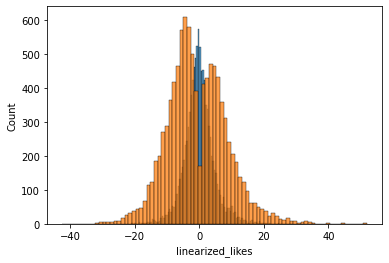

In [52]:
group1 = df[df.exp_group == 1].copy()
group2 = df[df.exp_group == 2].copy()

CTRcontrol = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()

group1['linearized_likes'] = df.apply(
    lambda x: linearized_likes(x['likes'], x['views'], CTRcontrol), axis=1)
group2['linearized_likes'] = df.apply(
    lambda x: linearized_likes(x['likes'], x['views'], CTRcontrol), axis=1)

CTRcontrol = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()

sns.histplot(group1.linearized_likes, 
             kde = False)
sns.histplot(group2.linearized_likes, 
             kde = False)

In [53]:
#T-тест самих групп

stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

In [54]:
#T-тест линеаризованных лайков

stats.ttest_ind(group1.linearized_likes,
                group2.linearized_likes,
                equal_var=False)

Ttest_indResult(statistic=5.93637710193448, pvalue=2.9805064038668164e-09)